In [40]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import folium
import os, sys
import fnmatch
from TOA_Reflectance_Stacker import histogram_stretch
from tqdm import tqdm
import earthpy.plot as ep
import shapely
from sklearn import cluster
from rasterio.plot import reshape_as_image
import matplotlib.patches as mpatches
from datetime import datetime
from matplotlib.colors import ListedColormap

In [2]:
# grab 'ground truth' data from maps
# want to try and get the most amount of variation in a single land-use type

land_use = gpd.read_file("land_use_training_set.geojson")
land_use = land_use.to_crs('EPSG:32652')
print(land_use.crs)

print(land_use.LULC.unique())

EPSG:32652
['Forest' 'Water' 'Urban' 'Cropland' 'Bare Land']


In [3]:
with rio.open('LC08_L2SP_113037_20210325_20210402_02_T1/LC08_L2SP_113037_20210325_20210402_02_T1_STACKED.tif') as src:
    profile = src.profile
    stack = src.read()
    src.close()
    
# change the stack from DNs to reflectances
# remember temperature uses a different scaling factor (temp is in Kelvin)
scaled_stack = stack[:-1,...] * 0.0000275 - 0.2
scaled_temp = stack[-1,...] * 0.00341802 + 149.0 

scaled_stack = np.vstack((scaled_stack, np.expand_dims(scaled_temp, axis = 0))) # need to change scaled_temp from 2D to 3D

# Conduct a histogram stretch of the study area
stretch_tcc = histogram_stretch(scaled_stack[[3,2,1], ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Jonny\anaconda3\envs\gdal_new\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

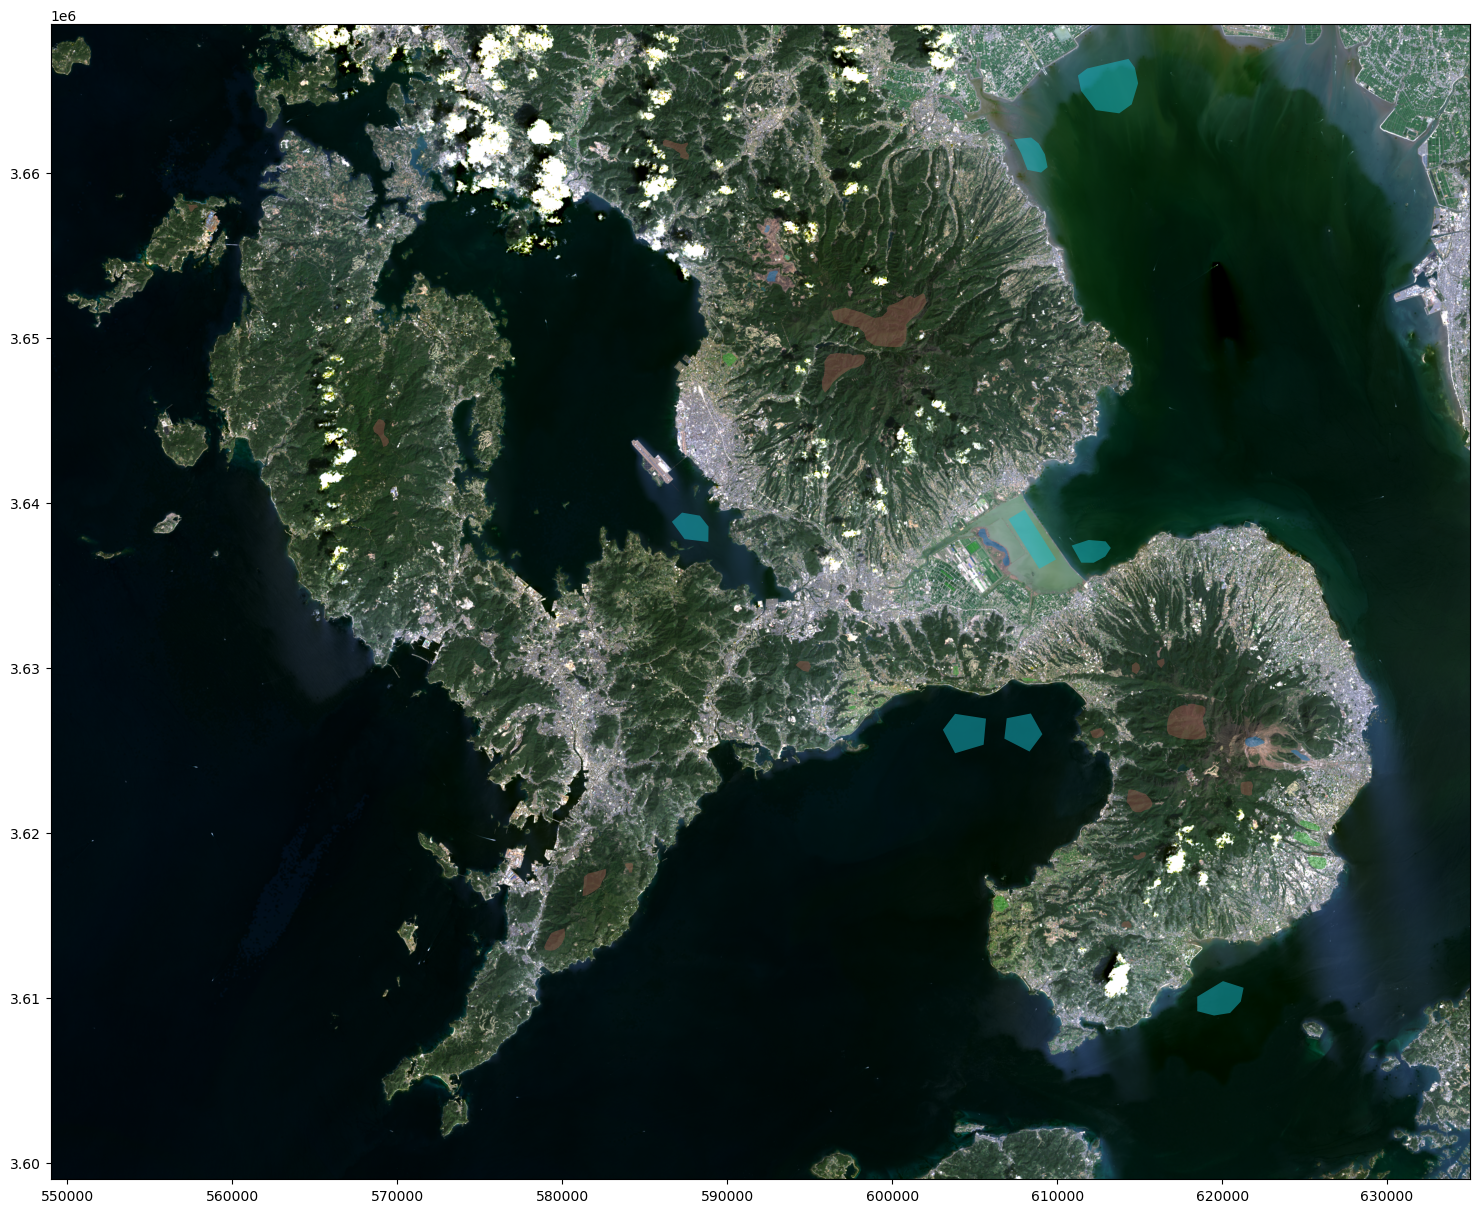

In [4]:
# show the location of the training data wrt the original image

fig, ax = plt.subplots(figsize = (20,15))

show(stretch_tcc, ax = ax, transform = profile['transform'])
land_use.plot(column = 'LULC', alpha = 0.5, ax = ax)

In [24]:
# To prep the data for ML analysis, we need two numpy arrays:
# X: a numpy array that contains all of the band data for the pixel
# y: the labels for training
X_train = np.array([], dtype = np.float32).reshape(0,8) # Create an array with 8 columns and 0 rows
                                                  # we're gonna stack new pixels inside
y_train = np.array([], dtype = np.string_) # labels for training

# note that although we have scaled_stack, rio.mask.mask requires a dataset in read mode
with rio.open("LC08_L2SP_113037_20210325_20210402_02_T1/LC08_L2SP_113037_20210325_20210402_02_T1_STACKED.tif") as src:
    profile = src.profile
    
    # Iterate over each polygon in our landuse ground truth dataset
    for index, row in land_use.iterrows():
        feature = [row["geometry"]]
        
        # crop the image - mask function returns a tuple
        out_image, out_transform = rio.mask.mask(src, feature, crop = True)

        # out_image has a shape (8, height, width)
        # Since this returns a rectangular array, and our shape is not rectangular, there will be
        # a bunch of nodata - get rid of them.
        
        # ~np.any(np.isnan(out_image), axis = 0) if any of the bands are np.nan
        
        # note that this gets rid of any column that has ANY nans
        # The following code returns a column for each band, with each row representing a pixel
        out_image_trimmed = out_image[:, ~np.any(out_image == profile['nodata'], axis = 0)]
        
        # We actually want this the other way around - we want a row for pixel, and a column for each
        # band - so we transpose the image
        out_image_trimmed = out_image_trimmed.T
        
        out_bands = out_image_trimmed[:,:-1] * 0.0000275 - 0.2
        out_temp = out_image_trimmed[:,-1] * 0.00341802 + 149.0 
        
        out_raster = np.hstack((out_bands, np.expand_dims(out_temp, axis = 1)))
        
        # We append the labels to the answer array equal to the number of pixels:
        # Remember to put brackets around the row["LULC"], or else you'll get "forestforestforest"
        # out_image_trimmed.shape[0] is the number of pixels in the training data
        y_train = np.append(y_train, [row["LULC"]] * out_raster.shape[0])
        
        # vstack is like concat for rows. Note that to vstack correctly, the array tuple that you feed
        # to vstack must have the same column dimension
        X_train = np.vstack((X_train, out_raster))

src.close()

In [25]:
# our X and y should have the same number of rows
print(X_train.shape)
print(y_train.shape)

(72047, 8)
(72047,)


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

gnb_clf = make_pipeline(StandardScaler(), GaussianNB())

# 5 fold cross-validation - shows one of them is really bad compared to the others
cross_val_score(gnb_clf, X_train, y_train, cv = 5, scoring='f1_macro')

array([0.72360339, 0.89682849, 0.80111729, 0.53799032, 0.75659121])

In [34]:
# Reshape our image into rows of pixels and columns of bands
X_test = scaled_stack.swapaxes(0,2).reshape(-1, 8)

print(X_test.shape)

# fit the data to our training set
gnb_clf.fit(X_train, y_train)

y_pred = gnb_clf.predict(X_test)

(6693912, 8)


In [36]:
# Get back the original image
nagasaki_pred = y_pred.reshape(scaled_stack.shape[2], scaled_stack.shape[1]).T

# nagasaki_pred currently a bunch of strings - convert to integers
lulc_dict = dict((
    ("Urban", 0),
    ("Cropland", 1),
    ("Forest", 2),
    ("Water", 3),
    ("Bare Land", 4),
))

# Invert dictionary
inv_dict = {v: k for k, v in lulc_dict.items()}

# replace all pixels with numbers

# apparently faster - returns unique values as well as the indices that can be used to reconstruct
# the array
u, inv = np.unique(nagasaki_pred, return_inverse = True)
nagasaki_pred = np.array([lulc_dict[x] for x in u])[inv].reshape(nagasaki_pred.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


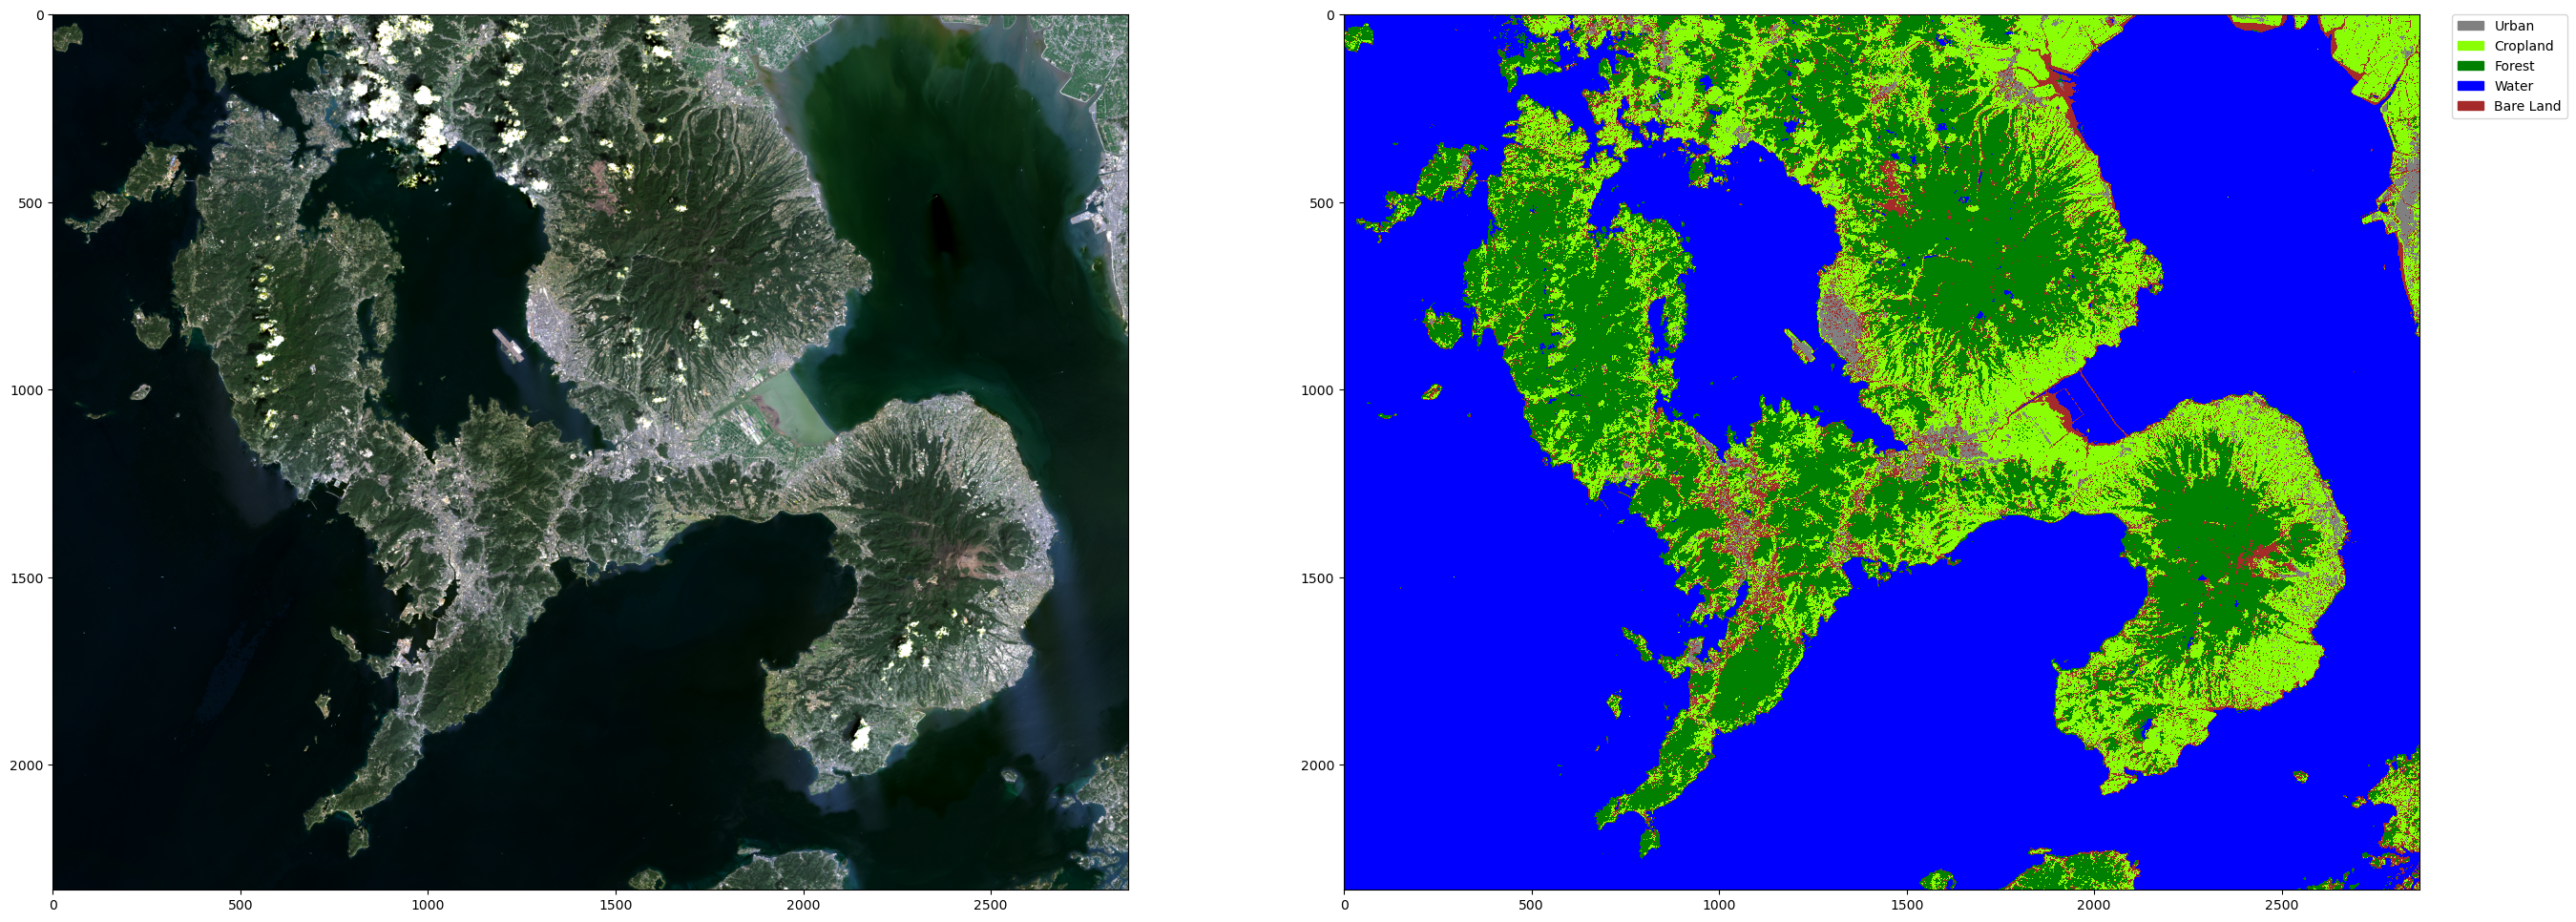

In [45]:
fig, ax = plt.subplots(1,2,figsize = (32,18))

colors = ["grey", "xkcd:lime green", "green", "blue", "brown"]
cmap = ListedColormap(colors)

ax[0].imshow(reshape_as_image(stretch_tcc))
ax[1].imshow(nagasaki_pred, cmap = cmap, interpolation='nearest')

patches = [mpatches.Patch(color=colors[i], label = inv_dict[i]) for i in range(len(np.unique(nagasaki_pred))) ]
plt.legend(handles=patches, bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0. )

In [43]:
nagasaki_pred

array([[3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1],
       [3, 3, 3, ..., 1, 1, 1]])

In [23]:
# testing hstack
test1 = np.arange(1,10).reshape(3,3)
test2 = np.array([2,5,8])

np.hstack((test1, np.expand_dims(test2, axis = 1)))

array([[1, 2, 3, 2],
       [4, 5, 6, 5],
       [7, 8, 9, 8]])

In [ ]:
# Create a sample 3D NumPy array
array_3d = np.array([[[1.0, 2.0, 3.0],
                      [4.0, 5.0, 6.0]],
                     [[0.0, 0.0, 0.0],
                      [7.0, 8.0, 9.0]],
                     [[10.0, 11.0, 12.0],
                      [13.0, 14.0, 15.0]]])

# Check if any values along axis 0 are equal to 0.0
any_zeros = np.any(array_3d == 0.0, axis=0)

# Print the result
array_3d[:, ~any_zeros].T

In [ ]:
profile